In [1]:
import datetime
from dateutil.relativedelta import relativedelta
import pandas as pd
from scipy import stats
import statsmodels.api as sm
import matplotlib.pyplot as plt
import warnings
from itertools import product
import matplotlib.pyplot as plt
import numpy as np

In [2]:
# функция, реализующая обратное преобразование Бокса-Кокса

def my_inv_boxcox(y, lmbda):
    if lmbda == 0:
        result = (np.exp(y))
    else:
        result = (np.exp(np.log(lmbda*y+1)/lmbda))
    return result

In [3]:
# обновленная версия датасета с данными по сентябрь 2021 включительно

data = pd.read_csv('updated_WAG_C_M.csv', sep=';', index_col=['month'], parse_dates=['month'],
                   dayfirst=True)

In [4]:
print(data)

            WAG_C_M
month              
1993-01-01     15.3
1993-02-01     19.1
1993-03-01     23.6
1993-04-01     30.6
1993-05-01     37.5
...             ...
2021-05-01  56171.0
2021-06-01  58782.0
2021-07-01  55170.0
2021-08-01  52355.0
2021-09-01  54687.0

[345 rows x 1 columns]


Text(0, 0.5, 'Средняя номинальная заработная плата')

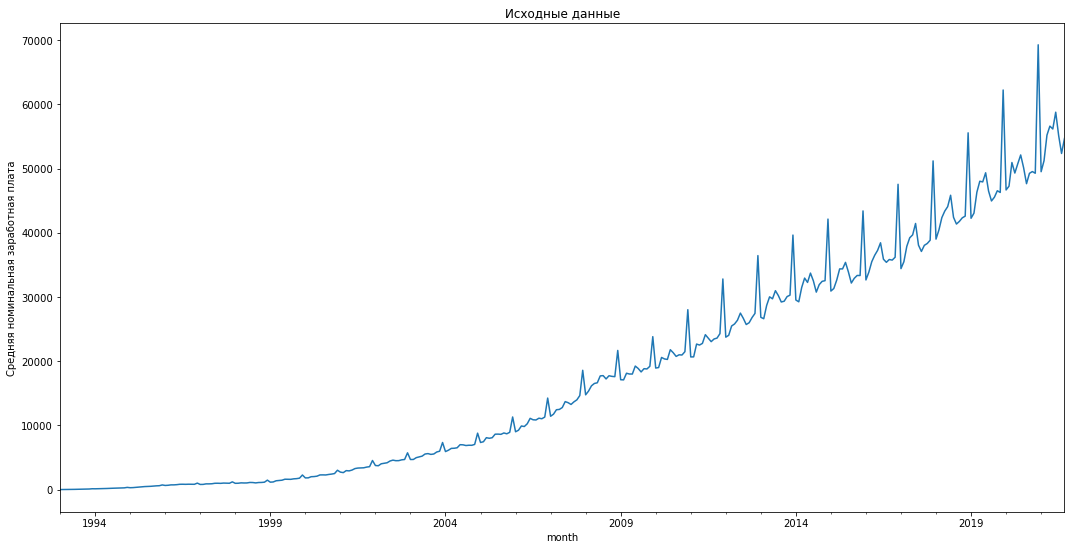

In [30]:
# ПУНКТ ПЕРВЫЙ - визульный анализ ряда.
# налицо и тренд, и сезонность, и увеличение дисперсии

plt.figure(figsize=(18,9))
data['WAG_C_M'].plot()
plt.title('Исходные данные')
plt.ylabel('Средняя номинальная заработная плата')

Оптимальный параметр преобразования Бокса-Кокса:
	 λ =  0.297417 



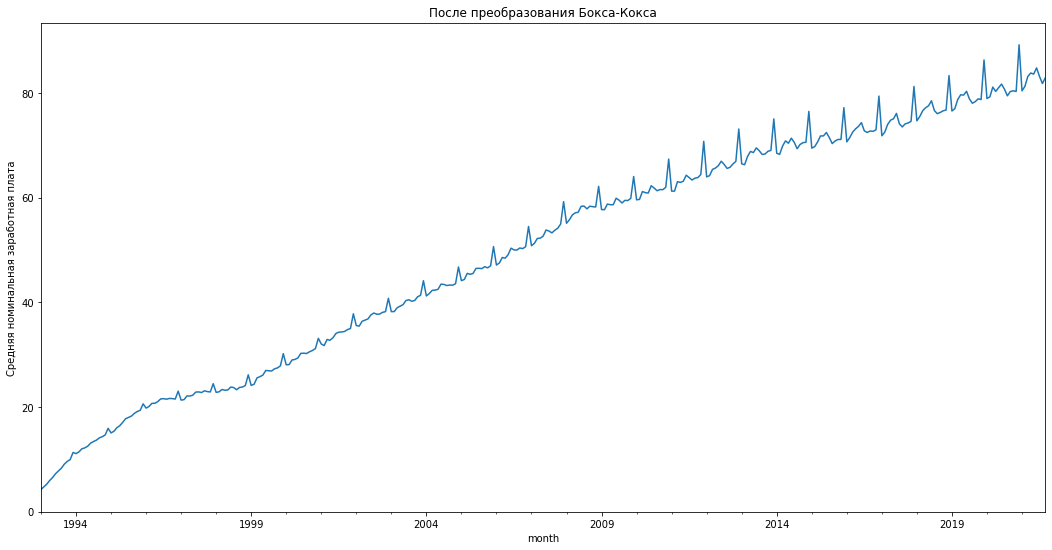

In [31]:
# ПУНКТ ВТОРОЙ - стабилизация дисперсии (при необходимости)
# исходя из визуальной оценки мы видим, что дисперсию нужно стабилизировать. Воспользуемся для этого преобразованием Бокса-Кокса

data['WAG_C_M_boxcox'], lmbda = stats.boxcox(data['WAG_C_M'])
plt.figure(figsize=(18,9))
data.WAG_C_M_boxcox.plot()
plt.title('После преобразования Бокса-Кокса')
plt.ylabel('Средняя номинальная заработная плата')

print('Оптимальный параметр преобразования Бокса-Кокса:')
print('\t \u03bb = ', round(lmbda, 6), '\n')

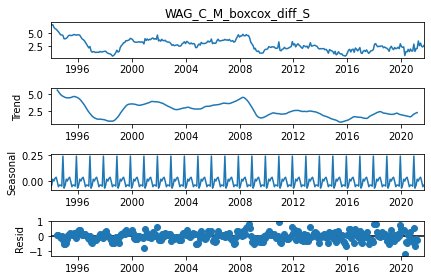

In [12]:
# ПУНКТ ТРЕТИЙ - выбор порядка дифференцирования
# преобразование Бокса-Кокса ожидаемо не избавило нас от тренда и сезонности. Чтобы сделать ряд стационарным, 
# попробуем его дифференцировать. Начнём с сезонного дифференцирования

S = 12 # длительность сезона (12 месяцев)
data['WAG_C_M_boxcox_diff_S'] = data.WAG_C_M_boxcox - data.WAG_C_M_boxcox.shift(S)
sm.tsa.seasonal_decompose(data.WAG_C_M_boxcox_diff_S[S:]).plot()
plt.show()

In [13]:
# оценивать стационарность ряда будем при помощи критерия Дики-Фуллера

print('\tp-value = ', round(sm.tsa.stattools.adfuller(data.WAG_C_M_boxcox_diff_S[S:])[1], 6))

# согласно критерию ряд не станционарный да и визуально отчётливо виден тренд

	p-value =  0.108466


<Figure size 1296x1080 with 0 Axes>

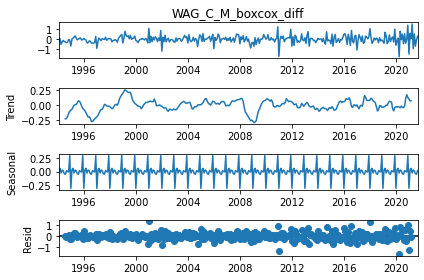

In [27]:
# чтобы всё-таки избавиться от тренда, попробуем ещё раз продифференцировать наш ряд, но уже не по сезонам

data['WAG_C_M_boxcox_diff'] = data.WAG_C_M_boxcox_diff_S - data.WAG_C_M_boxcox_diff_S.shift(1)
sm.tsa.seasonal_decompose(data.WAG_C_M_boxcox_diff[(S+1):]).plot()
plt.show()

In [15]:
# снова оцениваем стационарность ряда при помощи критерия Дики-Фуллера

print('\tp-value = ', round(sm.tsa.stattools.adfuller(data.WAG_C_M_boxcox_diff[(S+1):])[1], 6))

# гипотеза о нестационарности уверенно отвергается, тренд и остатки выглядят шумоподобно

	p-value =  0.003349


In [16]:
# зафиксируем промежуточные итоги

D, d = 1, 1
print('Количество сезонных и обычных дифференцирований:')
print('\t D = ', D)
print('\t d = ', d)

Количество сезонных и обычных дифференцирований:
	 D =  1
	 d =  1


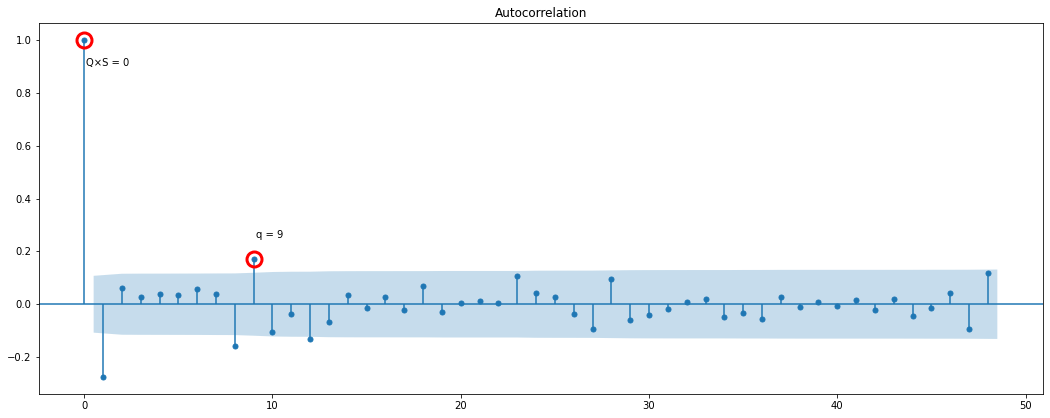

In [50]:
# ПУНКТ ЧЕТВЁРТЫЙ - выбор начальных приближений для p, q, P, Q
# начинаем с анализа автокорреляционной функции для отыскания q и Q

plt.figure(figsize=(18,15))
ax = plt.subplot(2,1,1)
sm.graphics.tsa.plot_acf(data.WAG_C_M_boxcox_diff[(S+1):].values.squeeze(), lags=4*S, ax=ax)
q, q_mark, q_text = 9, 0.17, 0.25
plt.plot(q, q_mark, marker='o', markerfacecolor=(1,1,0,0), markeredgecolor='r', markeredgewidth=3, markersize=15)
plt.text(q+0.1, q_text, 'q = {}'.format(q))
Q, Q_mark, Q_text = 0, 1, 0.9
plt.plot(Q, Q_mark, marker='o', markerfacecolor=(1,1,0,0), markeredgecolor='r', markeredgewidth=3, markersize=15)
plt.text(Q+0.1, Q_text, 'Q\u00d7S = {}'.format(Q))
Q = int(Q/S)

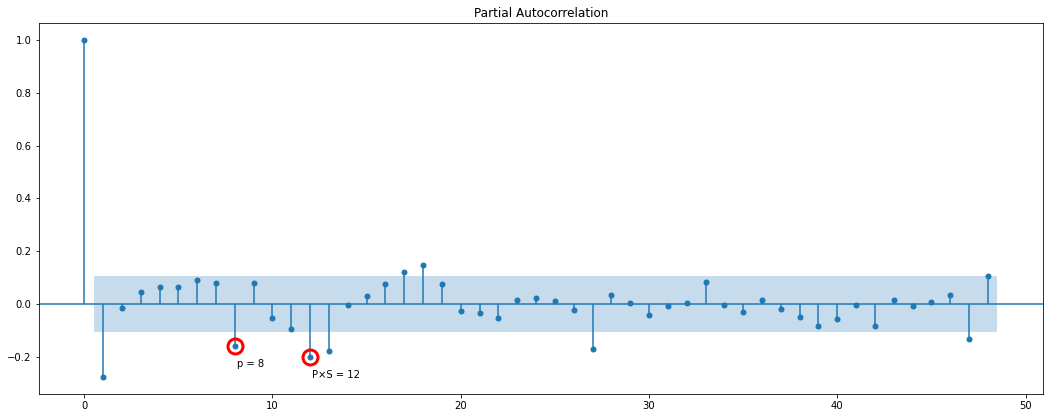

In [57]:
# теперь приступаем к анализу частичной автокорреляционной функции для отыскания p и P

plt.figure(figsize=(18,15))
ax = plt.subplot(2,1,2)
sm.graphics.tsa.plot_pacf(data.WAG_C_M_boxcox_diff[(S+1):].values.squeeze(), lags=4*S, ax=ax)
p, p_mark, p_text = 8, -0.16, -0.24
plt.plot(p, p_mark, marker='o', markerfacecolor=(1,1,0,0), markeredgecolor='r', markeredgewidth=3, markersize=15)
plt.text(p+0.1, p_text, 'p = {}'.format(p))
P, P_mark, P_text = 12, -0.2, -0.28
plt.plot(P, P_mark, marker='o', markerfacecolor=(1,1,0,0), markeredgecolor='r', markeredgewidth=3, markersize=15)
plt.text(P+0.1, P_text, 'P\u00d7S = {}'.format(P))
P = int(P/S)

In [58]:
# ещё раз зафиксируем промежуточные итоги

print('Начальные приближения из графика автокорреляционной функции:')
print('Q\u00d7S - номер последнего сезонного лага со значимой автокорреляцией')
print('q - номер последнего несезонного лага со значимой автокорреляцией')
print('\t Q = ', Q)
print('\t q = ', q)
P = int(P/S)
print('Начальные приближения из графика частичной автокорреляционной функции:')
print('P\u00d7S - номер последнего сезонного лага со значимой частичной автокорреляцией')
print('p - номер последнего несезонного лага со значимой автокорреляцией')
print('\t P = ', P)
print('\t p = ', p, '\n')

Начальные приближения из графика автокорреляционной функции:
Q×S - номер последнего сезонного лага со значимой автокорреляцией
q - номер последнего несезонного лага со значимой автокорреляцией
	 Q =  0
	 q =  9
Начальные приближения из графика частичной автокорреляционной функции:
P×S - номер последнего сезонного лага со значимой частичной автокорреляцией
p - номер последнего несезонного лага со значимой автокорреляцией
	 P =  0
	 p =  8 

